# Comparing 2D and 3D TSNE reductions of TESS data

The following is a notebook that takes a TESS simulated dataset and compares the outcome of 2D and 3D clustering, this is based on the observation that in previous reductions, 2D renders appear to have "Sliced Streams" that may cause seperate clusters to be classified where only one would be appropriate if in a higher dimension. 

This begs the question of what would happen to the data in other dimensions IE an equivalent "slicing" occuring when reducing from higher dimensions down to 3 dimensions that could lead to more clusters being found then are actually there.  

In [2]:
# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD as TSVD
from sklearn.manifold import TSNE
import os
%matplotlib inline
import hdbscan
from mpl_toolkits.mplot3d import Axes3D


# load and read dataset
train = os.path.join('TESS_simulated_lc_small.csv')

dataset = pd.read_csv(train, header=0, index_col=0)
dataset = dataset.reset_index()

# getting label and series points
Y = dataset['Ids']
X = dataset.iloc[0:, 1:]

# plot keywords for the plotting function used later
plot_kwds = {'alpha': 0.5, 's': 80, 'linewidths': 0}

# modules for reduction paramters based on previous experiments and can be 
# found in same repo directory. 

# random state fixed for replicability
tsvd = TSVD(n_components=50, n_iter=10000, algorithm='arpack', random_state=42)

tsne_2d = TSNE(n_components=2, n_iter=100000, n_iter_without_progress=1000, metric='manhattan',
               method='exact', learning_rate=1000, random_state=42)

tsne_3d = TSNE(n_components=3, n_iter=100000, n_iter_without_progress=1000, metric='manhattan',
               method='exact', learning_rate=1000, random_state=42)


#D3 reduction reduces the data set down to 3D for plotting 

D3_reduction = tsne_3d.fit_transform(tsvd.fit_transform(X))

#D2 then takes the 3D dataset and reduces it to two dimensions in order to comepare them 

D2_reduction = tsne_2d.fit_transform(tsvd.fit_transform(X))

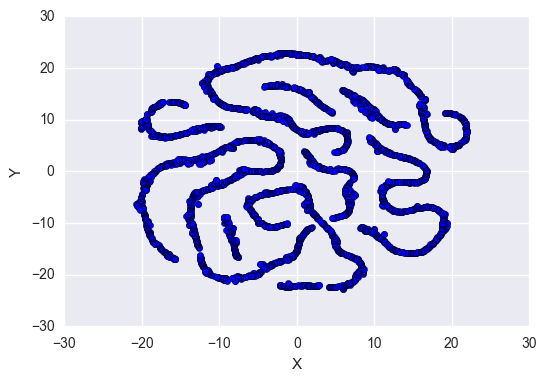

In [3]:
# scatter plotting the 2D dataset 

fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(D2_reduction.T[0], D2_reduction.T[1])

ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.show()

If we look at this figure it seems like various streams get "sliced", for example at X=0 Y=-20, there appears to be a discontinuation whereas it seems plausible that it should be a single unified stream. 

When we use HDBScan below, it (correctly) also clusteres these seperately.

found 9 clusters


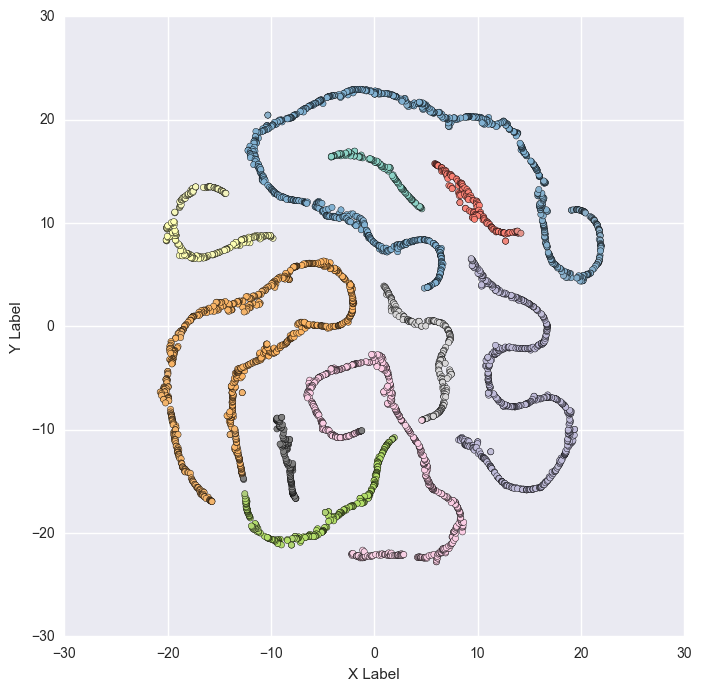

In [4]:
#initializing the clustering for 2D

clusterer = hdbscan.HDBSCAN(min_cluster_size = 125, min_samples=23).fit(D2_reduction)
n_clusters_ = len(set(clusterer.labels_)) - (1 if -1 in clusterer.labels_ else 0)


palette = sns.color_palette('Set3', n_colors=n_clusters_)
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (.5, .5, .5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]

# fig size and dpi allow to change figure sizes 
fig = plt.figure(figsize=(8,8), dpi=200)
ax = fig.add_subplot(111)
ax.scatter(D2_reduction.T[0], D2_reduction.T[1], c=cluster_colors)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')

print 'found {0} clusters'.format(n_clusters_)
plt.show()



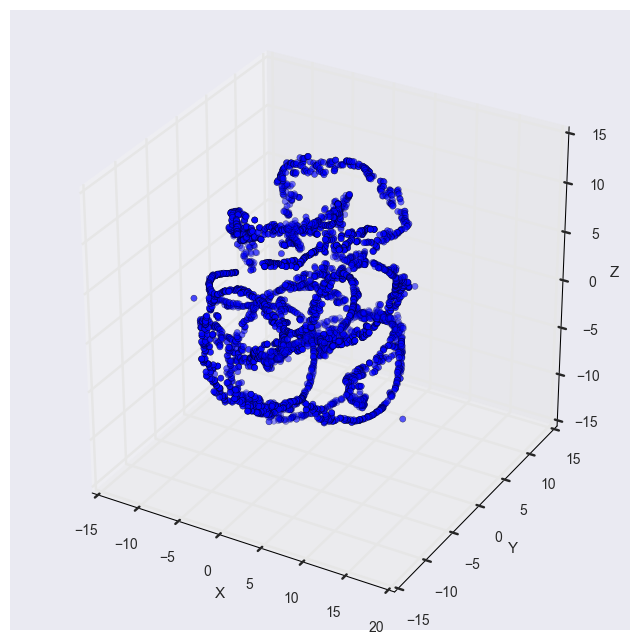

In [5]:
#now plotting the 3d rendering of the data

fig = plt.figure(figsize=(8,8), dpi=200)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(D3_reduction.T[0], D3_reduction.T[1], D3_reduction.T[2])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

Note that while slightly difficult to see one can enable interactivity with matplotlib nbagg, allowing you to manipulate and rotate the above figure to see the streams more clearly. Below we'll use HDBscan to cluster. 

found 4 clusters


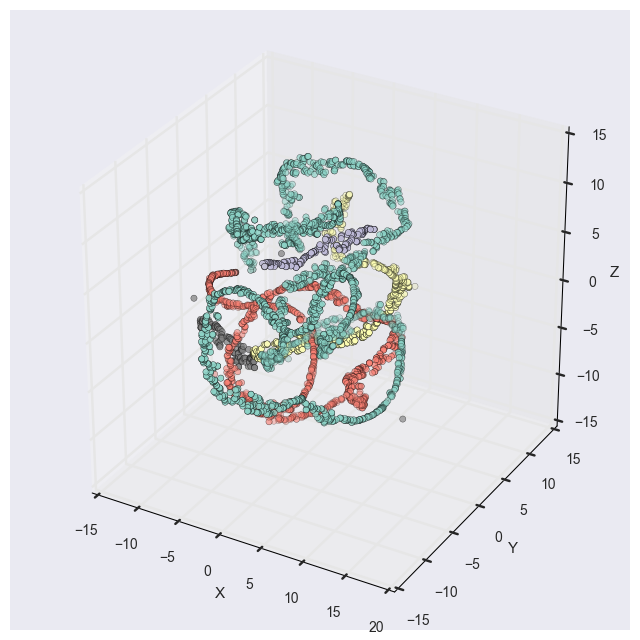

In [6]:
#initializing the 3d clustering 

clusterer = hdbscan.HDBSCAN(min_cluster_size = 125, min_samples=23).fit(D3_reduction)
n_clusters_ = len(set(clusterer.labels_)) - (1 if -1 in clusterer.labels_ else 0)


palette = sns.color_palette('Set3', n_colors=n_clusters_)
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (.5, .5, .5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]

fig = plt.figure(figsize=(8,8), dpi=200)
ax = fig.add_subplot(111, projection='3d')

ax.scatter(D3_reduction.T[0], D3_reduction.T[1], D3_reduction.T[2], c=cluster_colors)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

print 'found {0} clusters'.format(n_clusters_)

plt.show()

While its hard to follow the individual streams we can see the clusters interweave and also note that we get less clusters with the exact same parameters. 

From this we can expect to find this occuring in higher dimensions, how can we obtain correct clustering of high dimensional data given this behavior? A solution may be to set fixed parameters for a consistent amount of clusters over multiple dimensions. 

Once we have secured a secure amount of clusters, we can reduce the data and using the obtained parameters attempt to visualize where the clusters fall in the higher dimensions

## References:

- HDBScan: http://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html
- Scikit-Learn: http://scikit-learn.org/stable/
- Seaborn: http://seaborn.pydata.org/

Author: 
Nicholas Buchny